1. Implementing a simple variational autoencoder trained on the MNIST dataset

In [8]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 20*2)  # *2 for mean and log variance.
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)  # split the tensor into two
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, dataloader, optimizer):
    model.train()
    running_loss = 0.0
    for i, (data, _) in enumerate(dataloader):
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    return running_loss

def main():
    transform = transforms.Compose([transforms.ToTensor()])
    mnist = datasets.MNIST('./', download=True, transform=transform)
    dataloader = DataLoader(mnist, batch_size=32, shuffle=True)

    model = VAE()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(10):
        loss = train(model, dataloader, optimizer)
        print(f"Epoch {epoch+1}, Loss: {loss}")
    
    return model, dataloader  # return the trained model and the dataloader

if __name__ == "__main__":
    model, dataloader = main()  # save the returned model and dataloader in variables




Epoch 1, Loss: 8177681.200439453
Epoch 2, Loss: 6785456.8623046875
Epoch 3, Loss: 6596161.552978516
Epoch 4, Loss: 6503780.632080078
Epoch 5, Loss: 6450615.519775391
Epoch 6, Loss: 6411249.765869141
Epoch 7, Loss: 6382110.844238281
Epoch 8, Loss: 6356738.266357422
Epoch 9, Loss: 6336143.590576172
Epoch 10, Loss: 6317954.12109375


2. Qualitatively comparing images generated by Gaussian(1,2) distribution compared to Normal Distribution

Images generated from a Gaussian (1,2) distribution:


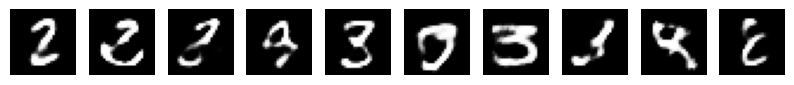

Images generated from a Normal distribution:


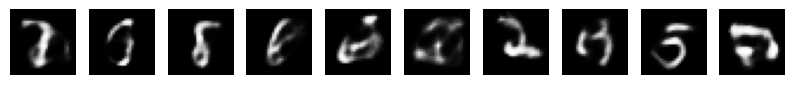

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def sample_and_decode(model, mu=0, std_dev=1, num_samples=10):
    # Sample from a Gaussian distribution
    z = torch.randn(num_samples, 20) * std_dev + mu
    # Decode the latent variables to generate images
    samples = model.decoder(z)
    return samples

def display_images(samples):
    # Reshape the samples and convert them to numpy arrays
    samples = samples.view(-1, 28, 28).detach().numpy()
    # Create a figure and axes
    fig, axes = plt.subplots(1, len(samples), figsize=(10, 2))
    # Display each image
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.show()

# Generating samples from a Gaussian (1,2) distribution and a Normal distribution
gaussian_samples = sample_and_decode(model, mu=1, std_dev=2)
normal_samples = sample_and_decode(model)

print("Images generated from a Gaussian (1,2) distribution:")
display_images(gaussian_samples)
print("Images generated from a Normal distribution:")
display_images(normal_samples)


3. Trying to find some useful parameters to be able to improve quality, though didn't help much

In [12]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import math

def compute_ssim(img1, img2):
    img1 = img1.detach().numpy()
    img2 = img2.detach().numpy()
    return ssim(img1, img2, multichannel=True, data_range=1.0)

def compute_psnr(img1, img2):
    img1 = img1.detach().numpy()
    img2 = img2.detach().numpy()
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# Compute SSIM and PSNR for a batch of images
for data, _ in dataloader:
    data = data.view(data.size(0), -1)
    recon_batch, _, _ = model(data)
    print("SSIM: ", compute_ssim(data, recon_batch))
    print("PSNR: ", compute_psnr(data, recon_batch))


SSIM:  0.881560601691607
PSNR:  19.197098007394416
SSIM:  0.8789908677170559
PSNR:  18.892428761784185
SSIM:  0.8717664509744818
PSNR:  18.82949701947051
SSIM:  0.8963106809512482
PSNR:  19.200534294468884
SSIM:  0.8760629560582266
PSNR:  18.727980628950647
SSIM:  0.8656227650173031
PSNR:  18.757742581008234
SSIM:  0.8771214223584818
PSNR:  19.123325000748476
SSIM:  0.8645831122993962
PSNR:  18.98245203318073
SSIM:  0.897748485315156
PSNR:  19.356510271987894
SSIM:  0.8776037292738219
PSNR:  18.50912710025
SSIM:  0.8973475797169996
PSNR:  19.224939475182225
SSIM:  0.893059790673435
PSNR:  19.326968910811562
SSIM:  0.8773259201120966
PSNR:  18.581851106046567
SSIM:  0.8805450893883661
PSNR:  18.910545842736198
SSIM:  0.8707453638008708
PSNR:  18.536142944200883
SSIM:  0.8741834726507954
PSNR:  18.554618464997002
SSIM:  0.8844724026582318
PSNR:  18.979937359124584
SSIM:  0.8672223366147765
PSNR:  18.888724458724937
SSIM:  0.8902644685907265
PSNR:  18.750174208414403
SSIM:  0.882681635715

Trying to implement some different techniques to get better quality image generation

Epoch 1, Loss: 8145158.916259766
Epoch 2, Loss: 6794931.960693359
Epoch 3, Loss: 6607437.518066406
Epoch 4, Loss: 6514540.692138672
Epoch 5, Loss: 6463170.689208984
Epoch 6, Loss: 6422173.482421875
Epoch 7, Loss: 6391938.105224609
Epoch 8, Loss: 6369396.345703125
Epoch 9, Loss: 6350547.902832031
Epoch 10, Loss: 6330755.1025390625
Images generated from a Gaussian (1,2) distribution:


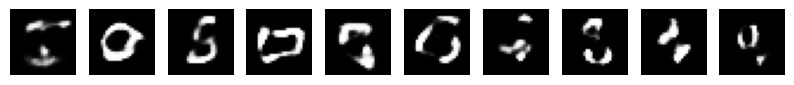

Images generated from a Normal distribution:


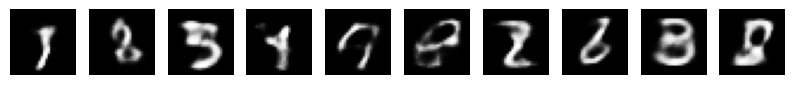

In [15]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 20*2)  # *2 for mean and log variance.
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)  # split the tensor into two
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Add a term to the loss function that encourages higher quality images
    quality_term = ((recon_x.var(dim=1) - 0.5) ** 2).sum()
    
    return BCE + KLD + quality_term

def train(model, dataloader, optimizer):
    model.train()
    running_loss = 0.0
    for i, (data, _) in enumerate(dataloader):
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    return running_loss

def main():
    transform = transforms.Compose([transforms.ToTensor()])
    mnist = datasets.MNIST('./', download=True, transform=transform)
    dataloader = DataLoader(mnist, batch_size=32, shuffle=True)

    model = VAE()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(10):
        loss = train(model, dataloader, optimizer)
        print(f"Epoch {epoch+1}, Loss: {loss}")
    
    return model, dataloader 

def display_images(samples):
    # Reshape the samples and convert them to numpy arrays
    samples = samples.view(-1, 28, 28).detach().numpy()
    # Create a figure and axes
    fig, axes = plt.subplots(1, len(samples), figsize=(10, 2))
    # Displaying each image
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.show()

if __name__ == "__main__":
    model, dataloader = main() 

    # Generating samples from a Gaussian (1,2) distribution and a Normal distribution
    gaussian_samples = sample_and_decode(model, mu=1, std_dev=2)
    normal_samples = sample_and_decode(model)

    print("Images generated from a Gaussian (1,2) distribution:")
    display_images(gaussian_samples)
    print("Images generated from a Normal distribution:")
    display_images(normal_samples)


Bonus - Doing the same task using Gamma(3,2) Distribution

Images generated from a Gamma (3,2) distribution:


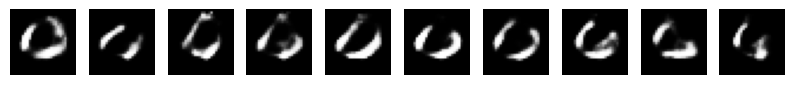

In [16]:
def sample_and_decode(model, shape=3, scale=2, num_samples=10):
    # Sample from a Gamma distribution
    gamma_dist = torch.distributions.Gamma(shape, scale)
    z = gamma_dist.sample((num_samples, 20))
    # Decode the latent variables to generate images
    samples = model.decoder(z)
    return samples

# Generating samples from a Gamma (3,2) distribution
gamma_samples = sample_and_decode(model, shape=3, scale=2)

print("Images generated from a Gamma (3,2) distribution:")
display_images(gamma_samples)
